In [1]:
import os
import sys
import pickle
import argparse
from scipy import sparse, io 
import numpy as np
import rpy2.robjects as robjects
import magic
import scprep
from sklearn.decomposition import NMF, non_negative_factorization, PCA
from sklearn.decomposition._nmf import _beta_divergence
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix 


script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions import simulate_multinomial_counts
from misc import *
from findK_correction_jk import *

import pdb

np.random.seed(123)

In [2]:
Yfile = "../../ebpmf_data_analysis/output/fastTopics_fit/sla_small.txt"
datafile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_fitted.Rds"
vocabfile="../../ebpmf_data_analysis/output/fastTopics_fit/sla_small_vocab.txt"
titlefile="../../ebpmf_data_analysis/data/SLA/title.sla.txt"

## load data and fitted L, F, s
Y = io.mmread(Yfile)
vocab = np.loadtxt(vocabfile, dtype = str)
readRDS = robjects.r['readRDS']
data = readRDS(datafile)
w_idx = np.asarray(data.rx2('word_idx')).astype(int)
fitted = data.rx2('fit_sub')
F = np.asarray(fitted.rx2('F'))
L = np.asarray(fitted.rx2('L'))
s = np.asarray(fitted.rx2('s'))
p, k = F.shape
n = L.shape[0]

C = L @ F.T
C = C.T @ C / n
Cbar = C / C.sum(axis = 1)[:, None]
w_true = C.sum(axis = 1)

## get all true anchor words
a_words = {}
for k_ in range(k):
    a_words[k_] = np.where(find_anchor_word_k2(F, k_) == True)[0]

In [3]:
np.random.seed(123)
X = simulate_multinomial_counts(L, F, np.round(s))

print(X.shape)

C_ = compute_C_unbiased(X)
Cbar_ = C_ / C_.sum(axis = 1)[:, None]
Cr, _, _ = rectifyC(C_, k, "AP") 
Cr_bar = Cr / Cr.sum(axis = 1)[:, None]

(3207, 2062)
+ Start alternating projection
+ Finish alternating projection
  - Elapsed seconds = 2.1694



In [4]:
S0, diagR0, _ = findS(Cbar, k)
S1, diagR1, _ = findS(Cbar_, k)
S2, diagR2, _ = findS(Cr_bar, k)
S3, diagR3 = findS_correction_jk(X, Cbar_, C_, k, prior_family = "point_normal")
S4, diagR4 = findS_correction_jk(X, Cr_bar, Cr, k, prior_family = "point_normal")

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0733 seconds

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0627 seconds

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 6 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0721 seconds



In [5]:
print((S0, X.sum(axis = 0)[S0.astype(int)]))
print((S1, X.sum(axis = 0)[S1.astype(int)]))
print((S2, X.sum(axis = 0)[S2.astype(int)]))
print((S3, X.sum(axis = 0)[S3.astype(int)]))
print((S4, X.sum(axis = 0)[S4.astype(int)]))

(array([1669, 1888,  178, 1666,  490, 1933]), array([426., 870., 620., 780., 485., 444.]))
(array([ 521, 1164,  891,  624,  962, 1837]), array([50., 27., 19., 16., 23., 26.]))
(array([ 891,  624, 1097,  726,  281, 1763]), array([19., 16., 17., 39., 19., 32.]))
(array([1669, 1891,  490,  178, 1666,  593]), array([426., 564., 485., 620., 780., 379.]))
(array([1925, 1888, 1669, 1666, 1411,  593]), array([ 59., 870., 426., 780., 349., 379.]))


### Compare against vanilla findK 

Note vanilla `findK` is not robust so simulated data from different seeds have very different results. Below I picked some bad results. Note that our robust `findK` si quite robust. 

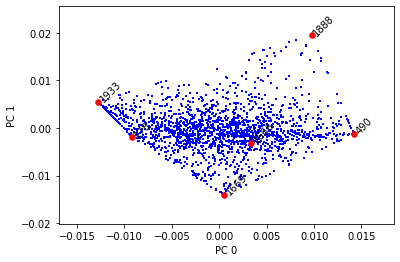

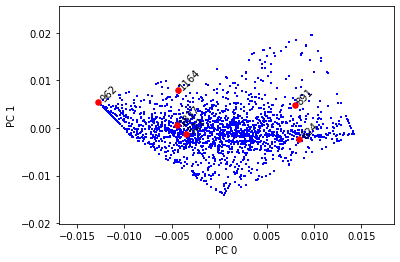

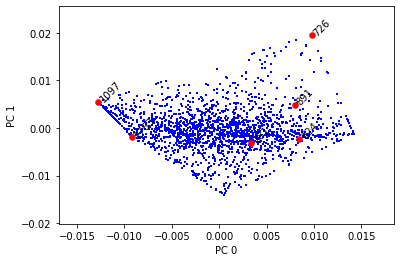

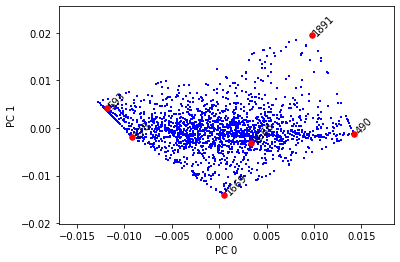

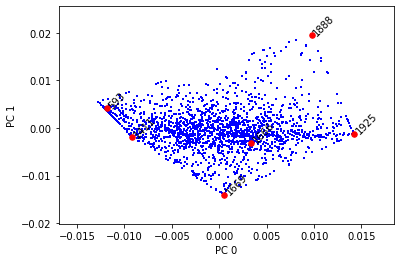

In [6]:
Cbar_pj = pca_proj(Cbar)
vis_extremal_pca(Cbar_pj, S0.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S1.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S2.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S3.astype(int), [0, 1], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S4.astype(int), [0, 1], annotate=True, fontsize=10)

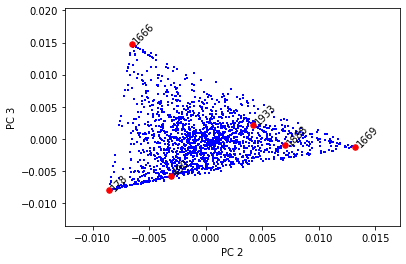

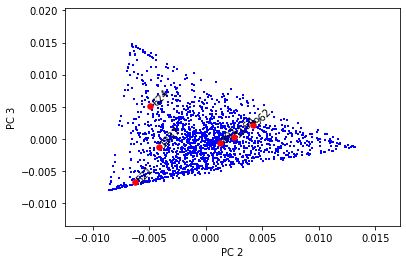

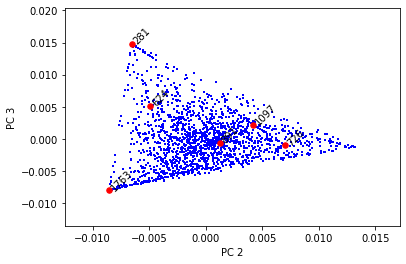

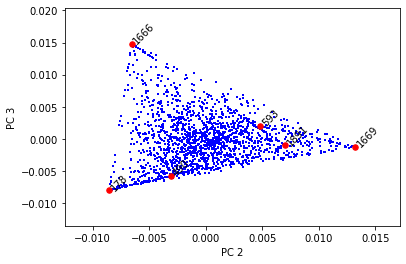

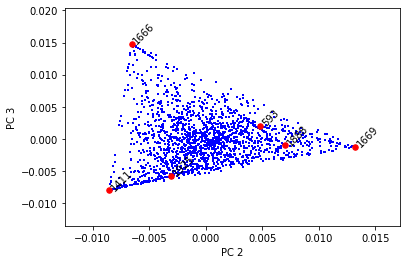

In [7]:
vis_extremal_pca(Cbar_pj, S0.astype(int), [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S1.astype(int), [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S2.astype(int), [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S3.astype(int), [2, 3], annotate=True, fontsize=10)
vis_extremal_pca(Cbar_pj, S4.astype(int), [2, 3], annotate=True, fontsize=10)